In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from voxmap import create_voxmap
from planning_utils import a_star, heuristic, create_grid
from planning_utils import a_star3D, heuristic3D, heuristic2D
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [8]:
def main():
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()

In [9]:
from planning_utils import a_star

In [10]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [11]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    max_p = 10
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    ri = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3) and ri < max_p:
            pruned_path.remove(pruned_path[i+1])
            ri += 1
        else:
            i += 1
            ri = 0
    return pruned_path

In [18]:
# TODO DONT WORK
def sendwp():
    print("sendwp")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)
    drone.start()
    drone.waypoints = [(316, 445, 0),
                        (317, 446, 11),
                        (317, 446, 22),
                        (317, 449, 33),
                        (317, 458, 42),
                        (325, 466, 53),
                        (325, 477, 64),
                        (325, 486, 75),
                        (325, 493, 86),
                        (325, 494, 87),
                        (324, 495, 88),
                        (324, 506, 88),
                        (324, 517, 88),
                        (324, 528, 88),
                        (324, 534, 88),
                        (323, 535, 87),
                        (322, 535, 76),
                        (322, 535, 65),
                        (321, 535, 54),
                        (321, 535, 43),
                        (321, 535, 32),
                        (321, 535, 31)]
    
    drone.send_waypoints()
#sendwp()

sendwp
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3974503   37.79248      0.138    ], local position [-0.07916737  0.23999657 -0.14187944]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.79248 -122.3974503 0.138
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-122.3974503   37.79248      0.138    ]
lp: [-0.04267759  0.26442216 -0.138     ]
gsf:  315.95732241217047 445.2644221645314
gs:  (316, 445, 0)


Traceback (most recent call last):
  File "/dd/env/fcnd/lib/python3.6/site-packages/udacidrone/drone.py", line 278, in notify_callbacks
    fn()
  File "<ipython-input-7-7352a6fafb08>", line 43, in state_callback
    self.plan_path()
  File "<ipython-input-16-643ca36b811b>", line 73, in plan_path
    voxel_shape = voxmap.shape
AttributeError: 'tuple' object has no attribute 'shape'


takeoff transition
waypoint transition


Traceback (most recent call last):
  File "/dd/env/fcnd/lib/python3.6/site-packages/udacidrone/drone.py", line 278, in notify_callbacks
    fn()
  File "<ipython-input-7-7352a6fafb08>", line 22, in local_position_callback
    self.waypoint_transition()
  File "<ipython-input-7-7352a6fafb08>", line 64, in waypoint_transition
    self.target_position = self.waypoints.pop(0)
IndexError: pop from empty list


landing transition
disarm transition
manual transition
Closing connection ...
Sending waypoints to simulator ...


main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3974504   37.7924802    0.205    ], local position [-0.02177989  0.25704348 -0.20546719]
North offset = -316, east offset = -445
(37.79248, -122.39745)  vs  (316, 445)
lla:  37.7924802 -122.3974504 0.205
gh:  [-122.3974533   37.7924804    0.       ]
gp:  [-122.3974504   37.7924802    0.205    ]
lp: [-0.02054439  0.25547462 -0.205     ]
gsf:  315.9794556093402 445.2554746173555
gs:  (316, 445, 0)
(921, 921, 250)
change [ 0.94039556 -0.36986559  0.21115022]
goal:  (-122.38804644442966, 37.788781544089346, 52.99255598065526)
lg:  [-405.00760668  830.91639679  -52.99255598]
ggf:  -89.00760668050498 1275.9163967944914
gg:  (321, 535, 30)  vg:  (321, 535, 30) False
Grid Start and Goal:  (316, 445, 0) (321, 535, 30)
Vox Start and Goal:  (316, 445, 0) (321, 535, 30)


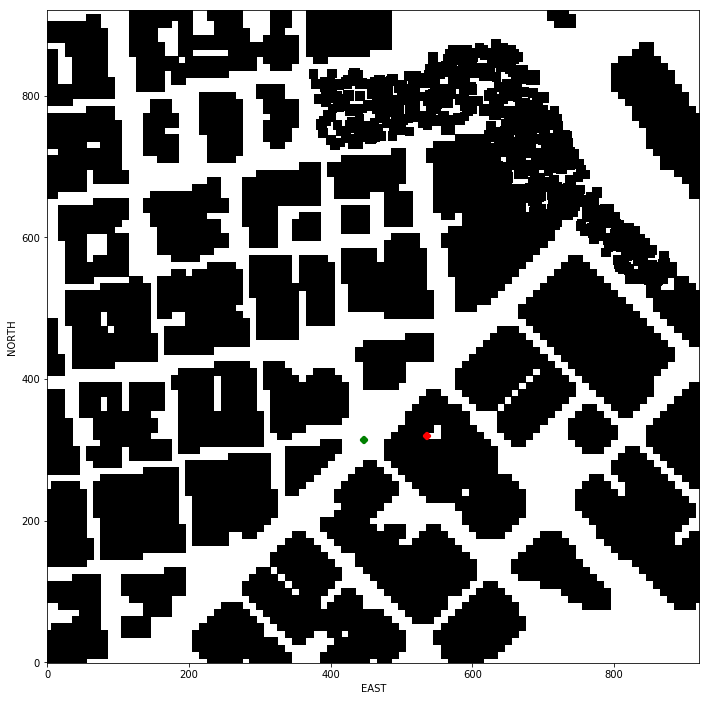

goal type: <class 'tuple'>, start type:<class 'tuple'>
D, DA: 1000 22807 CC: 35.92407448406448 HC: 68.09151861310727 QC: 104.01559309717175 CN: (319, 475, 12)
D, DA: 2000 47310 CC: 37.79898987322332 HC: 66.21660322394843 QC: 104.01559309717175 CN: (316, 477, 14)
D, DA: 4000 87939 CC: 29.752501608810682 HC: 74.26309148836108 QC: 104.01559309717177 CN: (319, 468, 14)
D, DA: 12000 174222 CC: 18.120955864630133 HC: 87.16598621332476 QC: 105.28694207795489 CN: (314, 460, 6)
D, DA: 14000 192757 CC: 34.853006672199 HC: 70.81944067446514 QC: 105.67244734666414 CN: (323, 476, 3)
D, DA: 15000 209561 CC: 23.166715171183775 HC: 82.75590139716269 QC: 105.92261656834646 CN: (313, 461, 15)
D, DA: 19000 256884 CC: 25.827698166887174 HC: 80.73059289185085 QC: 106.55829105873802 CN: (312, 465, 11)
D, DA: 21000 273312 CC: 35.21247447773741 HC: 71.63494553253256 QC: 106.84742001026996 CN: (312, 469, 24)
D, DA: 22000 286118 CC: 7.560477932315067 HC: 99.57679998734585 QC: 107.13727791966092 CN: (319, 446, 6

D, DA: 167000 1954396 CC: 42.702613556045996 HC: 81.17084391739479 QC: 123.8734574734408 CN: (317, 458, 37)
D, DA: 168000 1964902 CC: 75.34022991907148 HC: 48.63348761681452 QC: 123.973717535886 CN: (348, 502, 16)
D, DA: 170000 1995216 CC: 27.317108287336765 HC: 96.75857222765568 QC: 124.07568051499244 CN: (338, 454, 5)
D, DA: 176000 2055934 CC: 32.82842712474619 HC: 91.87831517751084 QC: 124.70674230225703 CN: (318, 445, 32)
D, DA: 177000 2069036 CC: 74.84742001026989 HC: 49.9547246503623 QC: 124.8021446606322 CN: (349, 503, 10)
D, DA: 178000 2086173 CC: 40.708684174891005 HC: 84.14140666587193 QC: 124.85009084076293 CN: (340, 460, 26)
D, DA: 182000 2127143 CC: 73.52200215938134 HC: 51.72306435728782 QC: 125.24506651666917 CN: (347, 495, 33)
D, DA: 185000 2156229 CC: 44.051829925398614 HC: 81.53104068079222 QC: 125.58287060619082 CN: (336, 460, 31)
D, DA: 186000 2173463 CC: 58.26163357264301 HC: 67.3689382127354 QC: 125.63057178537841 CN: (350, 486, 10)
D, DA: 187000 2186049 CC: 62.03

D, DA: 330000 3803481 CC: 73.98197502830806 HC: 63.269162107206085 QC: 137.25113713551414 CN: (348, 488, 46)
D, DA: 332000 3825773 CC: 32.73472163806186 HC: 104.66025403784438 QC: 137.39497567590624 CN: (326, 434, 25)
D, DA: 335000 3859145 CC: 89.2896129084478 HC: 48.34095887693057 QC: 137.63057178537838 CN: (356, 512, 18)
D, DA: 343000 3949849 CC: 58.001941872633935 HC: 80.17011495953578 QC: 138.17205683216972 CN: (329, 464, 46)
D, DA: 345000 3970558 CC: 49.65539633377431 HC: 88.66146695261935 QC: 138.31686328639367 CN: (354, 467, 8)
D, DA: 346000 3981952 CC: 73.09273152788217 HC: 65.3073928791967 QC: 138.40012440707886 CN: (364, 491, 19)
D, DA: 347000 3994891 CC: 73.61764951869964 HC: 64.83989147570693 QC: 138.45754099440657 CN: (361, 488, 34)
D, DA: 349000 4017611 CC: 57.50573217548032 HC: 81.09491840145928 QC: 138.6006505769396 CN: (314, 464, 49)
D, DA: 353000 4062072 CC: 59.787280521319474 HC: 79.07713843071048 QC: 138.86441895202995 CN: (337, 467, 44)
D, DA: 355000 4083975 CC: 70

D, DA: 499000 5747383 CC: 42.09564735931828 HC: 106.61157889985469 QC: 148.70722625917296 CN: (353, 448, 10)
D, DA: 501000 5770479 CC: 65.36820925487633 HC: 83.48309450066152 QC: 148.85130375553786 CN: (354, 469, 42)
D, DA: 502000 5781342 CC: 37.8700576850888 HC: 111.07106781186548 QC: 148.94112549695427 CN: (316, 426, 30)
D, DA: 504000 5806040 CC: 42.505003217621336 HC: 106.57679998734585 QC: 149.08180320496717 CN: (345, 439, 28)
D, DA: 511000 5887046 CC: 78.68944628842411 HC: 70.88225099390857 QC: 149.57169728233268 CN: (369, 484, 30)
D, DA: 513000 5911053 CC: 68.7483728625996 HC: 80.96570504440712 QC: 149.7140779070067 CN: (318, 467, 59)
D, DA: 514000 5922977 CC: 66.10438880865622 HC: 83.67924692336815 QC: 149.78363573202438 CN: (285, 471, 45)
D, DA: 515000 5942070 CC: 72.65733820640826 HC: 77.1569997630437 QC: 149.81433796945197 CN: (267, 486, 21)
D, DA: 517000 5967328 CC: 87.53152463770806 HC: 62.38331839513221 QC: 149.91484303284028 CN: (368, 504, 22)
D, DA: 519000 5992774 CC: 90

D, DA: 662000 7799730 CC: 84.1350389749541 HC: 75.31419245590071 QC: 159.4492314308548 CN: (271, 490, 51)
D, DA: 664000 7825759 CC: 36.095647359318285 HC: 123.49329386571753 QC: 159.58894122503582 CN: (285, 435, 3)
D, DA: 667000 7868940 CC: 47.99514229592993 HC: 111.77781011412252 QC: 159.77295241005245 CN: (319, 428, 40)
D, DA: 673000 7958701 CC: 66.7373924685548 HC: 93.3285726382975 QC: 160.0659651068523 CN: (368, 464, 21)
D, DA: 676000 7998566 CC: 88.22801550377935 HC: 72.03604389841357 QC: 160.2640594021929 CN: (373, 492, 37)
D, DA: 677000 8010567 CC: 97.81045422418394 HC: 62.5371112996372 QC: 160.34756552382115 CN: (368, 520, 4)
D, DA: 678000 8024879 CC: 47.80166070371629 HC: 112.60137953479867 QC: 160.40304023851496 CN: (292, 436, 35)
D, DA: 679000 8036545 CC: 56.33415930022651 HC: 104.12702648347513 QC: 160.46118578370164 CN: (337, 443, 47)
D, DA: 680000 8049226 CC: 87.2295254906271 HC: 73.3039930908447 QC: 160.5335185814718 CN: (315, 481, 72)
D, DA: 681000 8061199 CC: 101.99902

D, DA: 807000 9805404 CC: 53.7271931034988 HC: 114.53104068079222 QC: 168.258233784291 CN: (320, 427, 45)
D, DA: 808000 9821090 CC: 109.56217480400586 HC: 58.757843269796666 QC: 168.32001807380254 CN: (355, 514, 68)
D, DA: 810000 9847563 CC: 68.33270138450845 HC: 100.12216877940509 QC: 168.45487016391354 CN: (355, 455, 49)
D, DA: 811000 9861321 CC: 45.56581959330103 HC: 122.94112549695429 QC: 168.50694509025533 CN: (297, 422, 30)
D, DA: 812000 9874036 CC: 98.44947643179783 HC: 70.13236814446111 QC: 168.58184457625896 CN: (355, 491, 67)
D, DA: 814000 9900487 CC: 60.34241679264859 HC: 108.36213863603139 QC: 168.70455542867998 CN: (311, 441, 57)
D, DA: 816000 9927050 CC: 105.43441936267169 HC: 63.40935585830306 QC: 168.84377522097475 CN: (376, 517, 27)
D, DA: 817000 9941336 CC: 69.8057894499273 HC: 99.10098902030428 QC: 168.9067784702316 CN: (300, 455, 60)
D, DA: 820000 9981191 CC: 101.15208998784382 HC: 67.9479250736583 QC: 169.10001506150212 CN: (375, 509, 40)
D, DA: 825000 10048551 CC:

D, DA: 957000 11945191 CC: 115.83425274264803 HC: 61.41688439286608 QC: 177.2511371355141 CN: (375, 524, 39)
D, DA: 958000 11958808 CC: 71.63154574418051 HC: 105.69362710576496 QC: 177.3251728499455 CN: (324, 446, 68)
D, DA: 959000 11973494 CC: 56.6580671642673 HC: 120.72646414563982 QC: 177.38453130990712 CN: (348, 428, 38)
D, DA: 964000 12042470 CC: 60.55489127038595 HC: 117.16865704381775 QC: 177.7235483142037 CN: (287, 437, 46)
D, DA: 966000 12071835 CC: 87.45778599534958 HC: 90.35655197410235 QC: 177.8143379694519 CN: (384, 482, 13)
D, DA: 968000 12100970 CC: 59.61230785771365 HC: 118.22340280065245 QC: 177.8357106583661 CN: (339, 429, 45)
D, DA: 972000 12159843 CC: 74.75663035502168 HC: 103.30059330249267 QC: 178.05722365751436 CN: (322, 449, 71)
D, DA: 973000 12176794 CC: 65.07033885400642 HC: 113.03871472890656 QC: 178.10905358291296 CN: (374, 449, 14)
D, DA: 974000 12191265 CC: 65.14553541208292 HC: 113.01219330881976 QC: 178.1577287209027 CN: (321, 434, 59)
D, DA: 977000 1223

D, DA: 1106000 14100637 CC: 99.32512077881567 HC: 86.61764951869968 QC: 185.94277029751535 CN: (355, 477, 73)
D, DA: 1108000 14129510 CC: 95.63882927780041 HC: 90.42761978596782 QC: 186.06644906376823 CN: (382, 477, 47)
D, DA: 1110000 14158167 CC: 70.61430180147738 HC: 115.58214164833183 QC: 186.1964434498092 CN: (365, 444, 50)
D, DA: 1111000 14171820 CC: 110.75492743836047 HC: 75.50913196383237 QC: 186.26405940219286 CN: (386, 515, 37)
D, DA: 1112000 14186796 CC: 101.85956124795987 HC: 84.4706561908987 QC: 186.33021743885857 CN: (371, 483, 67)
D, DA: 1113000 14200802 CC: 63.90143680924558 HC: 122.4967457251993 QC: 186.39818253444489 CN: (365, 432, 26)
D, DA: 1114000 14214656 CC: 53.97396253682911 HC: 132.4850363732955 QC: 186.4589989101246 CN: (269, 432, 5)
D, DA: 1115000 14233313 CC: 66.99514229592991 HC: 119.4994165556923 QC: 186.49455885162223 CN: (375, 442, 17)
D, DA: 1116000 14247407 CC: 46.588457268119875 HC: 139.9698337906181 QC: 186.55829105873798 CN: (325, 405, 9)
D, DA: 1119

D, DA: 1231000 15948272 CC: 103.8383814888591 HC: 89.42416792648604 QC: 193.26254941534512 CN: (265, 485, 70)
D, DA: 1235000 16004727 CC: 85.59579287286951 HC: 107.92795822933243 QC: 193.52375110220194 CN: (371, 457, 59)
D, DA: 1236000 16024532 CC: 123.34829448168011 HC: 70.21320343559643 QC: 193.56149791727654 CN: (385, 535, 15)
D, DA: 1238000 16056570 CC: 80.71407790700667 HC: 112.95326673464427 QC: 193.66734464165094 CN: (367, 450, 58)
D, DA: 1241000 16106913 CC: 103.32784368043835 HC: 90.48649428901354 QC: 193.81433796945188 CN: (392, 501, 13)
D, DA: 1243000 16140469 CC: 57.68337566957913 HC: 136.1920236764956 QC: 193.87539934607474 CN: (332, 404, 28)
D, DA: 1244000 16153507 CC: 67.3375590885785 HC: 126.58359956404986 QC: 193.92115865262838 CN: (309, 423, 56)
D, DA: 1245000 16168017 CC: 69.12702648347509 HC: 124.85834833318499 QC: 193.98537481666008 CN: (300, 428, 57)
D, DA: 1247000 16199085 CC: 103.74807579052687 HC: 90.35042928412759 QC: 194.09850507465444 CN: (255, 500, 61)
D, D

D, DA: 1353000 17799117 CC: 84.57679998734578 HC: 115.44267685509386 QC: 200.01947684243964 CN: (292, 447, 74)
D, DA: 1354000 17813909 CC: 111.03453391156573 HC: 89.04357243297659 QC: 200.07810634454233 CN: (391, 499, 43)
D, DA: 1356000 17842940 CC: 100.90556555545662 HC: 99.29913538677465 QC: 200.20470094223128 CN: (330, 463, 89)
D, DA: 1357000 17857744 CC: 65.00461270312691 HC: 135.26916210720609 QC: 200.273774810333 CN: (294, 416, 46)
D, DA: 1358000 17872946 CC: 127.44467079885743 HC: 72.89876597875265 QC: 200.34343677761007 CN: (386, 539, 14)
D, DA: 1359000 17887990 CC: 115.9963552107048 HC: 84.40716898472601 QC: 200.4035241954308 CN: (336, 490, 91)
D, DA: 1364000 17965769 CC: 108.44680560130483 HC: 92.22048696921638 QC: 200.66729257052123 CN: (352, 475, 84)
D, DA: 1365000 17983021 CC: 67.77781011412249 HC: 132.9238294831214 QC: 200.7016395972439 CN: (379, 435, 2)
D, DA: 1367000 18014599 CC: 71.80651840778634 HC: 128.9914975066349 QC: 200.79801591442123 CN: (383, 439, 7)
D, DA: 136

D, DA: 1476000 19702989 CC: 82.18230826835543 HC: 124.42149709599305 QC: 206.6038053643485 CN: (361, 437, 61)
D, DA: 1479000 19748704 CC: 117.17890848000341 HC: 89.59652183072863 QC: 206.77543031073205 CN: (313, 489, 98)
D, DA: 1481000 19778924 CC: 83.83163398328479 HC: 123.04551430561057 QC: 206.87714828889534 CN: (376, 443, 56)
D, DA: 1483000 19807685 CC: 114.04818513610343 HC: 92.94452528530628 QC: 206.9927104214097 CN: (240, 510, 35)
D, DA: 1486000 19851636 CC: 115.37622174635534 HC: 91.78728052131952 QC: 207.16350226767486 CN: (245, 513, 51)
D, DA: 1488000 19880766 CC: 83.20348802745625 HC: 124.07835134548543 QC: 207.28183937294168 CN: (365, 439, 61)
D, DA: 1489000 19896076 CC: 137.72014852585158 HC: 69.61303681557271 QC: 207.3331853414243 CN: (335, 523, 90)
D, DA: 1491000 19927578 CC: 117.78655156346043 HC: 89.66000903690131 QC: 207.44656060036175 CN: (291, 484, 89)
D, DA: 1492000 19941498 CC: 104.3129795411257 HC: 103.19863032338633 QC: 207.51160986451202 CN: (312, 462, 96)
D, D

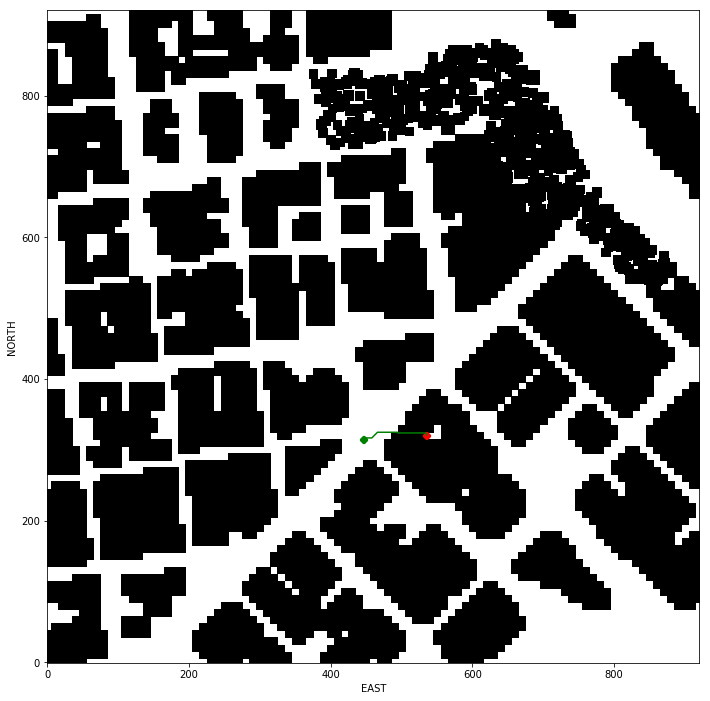

22


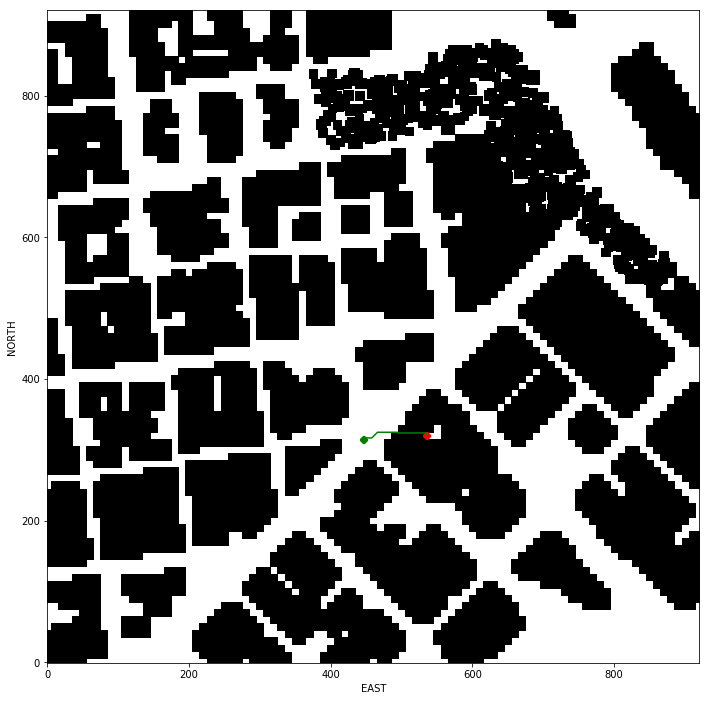

A* path:
(316, 445, 0) False
(317, 446, 1) False
(317, 446, 2) False
(317, 446, 3) False
(317, 446, 4) False
(317, 446, 5) False
(317, 446, 6) False
(317, 446, 7) False
(317, 446, 8) False
(317, 446, 9) False
(317, 446, 10) False
(317, 446, 11) False
(317, 446, 12) False
(317, 446, 13) False
(317, 446, 14) False
(317, 446, 15) False
(317, 446, 16) False
(317, 446, 17) False
(317, 446, 18) False
(317, 446, 19) False
(317, 446, 20) False
(317, 446, 21) False
(317, 446, 22) False
(317, 446, 23) False
(317, 446, 24) False
(317, 446, 25) False
(317, 446, 26) False
(317, 446, 27) False
(317, 446, 28) False
(317, 446, 29) False
(317, 446, 30) False
(317, 447, 31) False
(317, 448, 32) False
(317, 449, 33) False
(317, 450, 34) False
(317, 451, 35) False
(317, 452, 36) False
(317, 453, 37) False
(317, 454, 38) False
(317, 455, 39) False
(317, 456, 40) False
(317, 457, 41) False
(317, 458, 42) False
(318, 459, 43) False
(319, 460, 44) False
(320, 461, 45) False
(321, 462, 46) False
(321, 462, 47)

In [16]:
def plan_path(self, twoD=False):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5
    VOXEL_SIZE = 1
    MAX_ALTITUDE = 250

    self.target_position[2] = TARGET_ALTITUDE

    # TODO: read lat0, lon0 from colliders into floating point values

    # TODO: set home position to (lon0, lat0, 0)

    # TODO: retrieve current global position

    # TODO: convert to current local position using global_to_local()

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    if not twoD:
        voxmap = create_voxmap(data, safety_distance=SAFETY_DISTANCE, max_altitude=MAX_ALTITUDE, voxel_size=1)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    self.set_home_position(lat0, lon0, 0)
    print((lon0, lat0), " vs ", (-north_offset, -east_offset))    
    print("lla: ",self._latitude, self._longitude, self._altitude)
    print("gh: ",self.global_home)
    print("gp: ",self.global_position)
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    print("lp:", local_pos)
    north, east, att = local_pos
    print("gsf: ", (north - north_offset), (east - east_offset))

    #2d
    #3d
    if twoD:
        grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    else:
        grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)), int(np.rint(self.global_position[2])))
    
    #grid_start = (316, 475, 30)
    
    vox_start = (grid_start[0] // VOXEL_SIZE,
             grid_start[1] // VOXEL_SIZE,
             grid_start[2] // VOXEL_SIZE)    
    print("gs: ",grid_start)
    

    
    # Set goal as some arbitrary position on the grid
    #grid_goal = (-north_offset + 10, -east_offset + 10)
    # TODO: adapt to set goal as latitude / longitude position and convert
    # grid_goal = (grid_start[0] + 10, grid_start[1] + 10)
    #goal = (-122.400600, 37.793401, 0)
    #goal = (lat0 + 0.0001, lon0 + 0.00001, 0)
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    voxel_shape = voxmap.shape
    print(voxel_shape)
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change[1:2] -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * float(MAX_ALTITUDE))
        print("goal: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("lg: ", local_goal)
        ng, eg, ag = local_goal
        print("ggf: ", (ng - north_offset), (eg - east_offset))
        #2d vs 3d
        if twoD:
            grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        else:
            grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)), int(np.rint(goal[2])))

#         grid_goal = (310,500,100)
        
#         grid_goal = (grid_start[0] - 8,
#                      grid_start[1] + 50,
#                      grid_start[2] + 95)

        grid_goal = (grid_start[0] + 5,
                     grid_start[1] + 100,
                     grid_start[2] + 30)

        vox_goal = (grid_goal[0] // VOXEL_SIZE,
                     grid_goal[1] // VOXEL_SIZE,
                     grid_goal[2] // VOXEL_SIZE)
        
        if vox_goal[0] >= voxel_shape[0]:
            vox_goal = (voxel_shape[0] - 1, vox_goal[1], vox_goal[2])
        elif vox_goal[0] < 1:
            vox_goal = (1, vox_goal[1], vox_goal[2])
        if vox_goal[1] >= voxel_shape[1]:
            vox_goal = (grid_goal[0], voxel_shape[1] - 1, vox_goal[2])
        elif vox_goal[1] < 1:
            vox_goal = (vox_goal[0], 1, vox_goal[2])
                    
        if twoD:
            goal_obs = grid[grid_goal[0], grid_goal[1]]
        else:
            goal_obs = voxmap[vox_goal[0], vox_goal[1], vox_goal[2]]
        print("gg: ",grid_goal, " vg: ", vox_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
    
    #grid_goal = (grid_start[0] + 10, grid_start[1] + 10,0)    
    #print("gg: ",grid_goal, " vg: ", vox_goal)
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Grid Start and Goal: ', grid_start, grid_goal)
    print('Vox Start and Goal: ', vox_start, vox_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    # 2d vs 3d
    if twoD:
        path, cost = a_star(grid, heuristic, grid_start, grid_goal)
    else:
        path, cost = a_star3D(voxmap, heuristic3D, grid_start, grid_goal)
    print(len(path), cost)
    plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    pruned_path = prune_path(path)
    print(len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
        
    print("A* path:")
    for p in path:
        print(p, voxmap[p[0], p[1], p[2]])
        
    print("Pruned_path:")
    for p in pruned_path:
        print(p)
    #    print(p, p.cost, p.delta, (p.delta[0] + north_offset, p.delta[1] + east_offset, TARGET_ALTITUDE, 0))
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!

    # Convert path to waypoints
    #waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
    if twoD:
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    else:
        waypoints = [[p[0] + north_offset, p[1] + east_offset, p[2], 0] for p in path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main()

In [ ]:
err

In [ ]:
main()

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [ ]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=0)

In [ ]:
#first_line = ""
with open('colliders.csv') as f:
    first_line = f.readline().strip()
print(first_line)    
latlon = first_line.split(',')
gs = float(latlon[0].strip().split(' ')[1])
ge = float(latlon[1].strip().split(' ')[1])
print(gs, ge)

In [ ]:
print(first_line.strip())